# Get Tracks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import clickpoints

# load the example data
clickpoints.loadExample("magnetic_tweezer")

## Get all Tracks

We query all the tracks found in the database and iterate over them. For each track we get the points as an Nx2 array.

Be aware that this method does not handle well tracks with missing data points.

In [2]:
# open database
with clickpoints.DataFile("track.cdb") as db:
    # get all tracks
    tracks = db.getTracks()

    # iterate over all tracks
    for track in tracks:
        print(track.type.name, track.points.shape)

tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)
tracks (68, 2)


## Get Complete Track Array

We can also receive all the tracks of the database in one array. This is usually quicker for large databases than querying each track separately. The resulting array is (Number of tracks)x(Number of images)x2. If a track does not have a marker in one images, np.nan values are filled into the array.

In [3]:
# open database
with clickpoints.DataFile("track.cdb") as db:
    data = db.getTracksNanPadded()
    print(data.shape)

(12, 68, 2)


## Plot Track Displacement

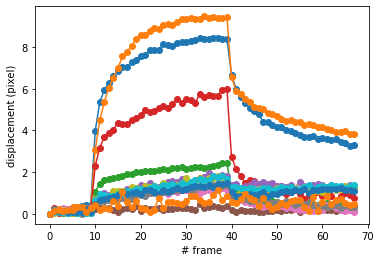

In [4]:
# open database
with clickpoints.DataFile("track.cdb") as db:
    # get all tracks
    tracks = db.getTracks()

    # iterate over all tracks
    for track in tracks:
        # get the points
        points = track.points
        # calculate the distance to the first point
        distance = np.linalg.norm(points[:, :] - points[0, :], axis=1)
        # plot the displacement
        plt.plot(track.frames, distance, "-o")

# label the axes
plt.xlabel("# frame")
plt.ylabel("displacement (pixel)");

We can do the same with the complete track array, which is especially for large databases significantly faster than querying each track separately.

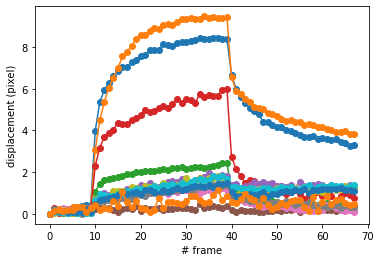

In [5]:
# open database
with clickpoints.DataFile("track.cdb") as db:
    # get all tracks (tracks x images x 2)
    points = db.getTracksNanPadded()

# get the distance to the first point of each track
distance = np.linalg.norm(points[:, :, :] - points[:, 0:1, :], axis=2)

# plot the distances
plt.plot(distance.T, "-o")

# label the axes
plt.xlabel("# frame")
plt.ylabel("displacement (pixel)");

## Plot Track Trajectories

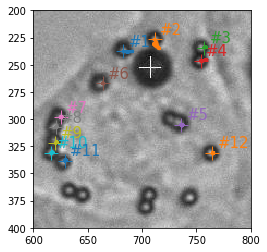

In [6]:
# open database
with clickpoints.DataFile("track.cdb") as db:
    # get the first image
    im_entry = db.getImage(0)

    # we load the pixel data from the Image database entry
    im_pixel = im_entry.data

    # plot the image
    plt.imshow(im_pixel, cmap="gray")

    # iterate over all tracks
    for track in tracks:
        # get the points
        points = track.points
        # plot the beginning of the track
        cross, = plt.plot(points[0, 0], points[0, 1], '+', ms=14, mew=1)
        # plot the track with the same color
        plt.plot(points[:, 0], points[:, 1], lw=3, color=cross.get_color())
        # plot the track id with a little offset and the same color
        plt.text(points[0, 0]+5, points[0, 1]-5, "#%d" % track.id, color=cross.get_color(), fontsize=15)

# zoom into the image
plt.xlim(600, 800)
plt.ylim(400, 200);

## Creating Tracks

In [7]:
from pathlib import Path

# Fix the seed
np.random.seed(0)

# we want 10 tracks
N = 10

# open database
with clickpoints.DataFile("tracking.cdb", "w") as db:

    # add a marker type we want to use for adding track markers
    # it has the name "trajectories" and the color "#FF0000", e.g. red
    # make it a type for tracks markers (TYPE_Track)
    track_type = db.setMarkerType(name="trajectories", color="#FF0000", mode=db.TYPE_Track)
    
    # create the new tracks with the type
    # (Note, instead of giving the track type, we could also just provide its name "trajectories"
    tracks = []
    for i in range(N):
        track = db.setTrack(type=track_type)
        tracks.append(track)
    
    # Create initial positions
    points = np.random.rand(N, 2)
        
    
    # find all images in the folder and iterate over them
    for image_filename in Path(".").glob("frame*.jpg"):
        
        # add the image to the database
        im = db.setImage(image_filename)
           
        # Move the positions (in this case we just create random walk tracks)
        points += np.random.rand(N, 2)-0.5

        # Save the new positions
        db.setMarkers(image=im, x=points[:, 0], y=points[:, 1], track=tracks)            